<a href="https://colab.research.google.com/github/lucasbens/ML_projects/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic

## Import data

In [504]:
# we have to restart runtime
!pip install lazypredict

In [505]:
# Import the data from Kaggle API
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = "bensaidlucas" # username from the json file
os.environ['KAGGLE_KEY'] = "e66b7ce0f4e8abb888db31a380aeb61d" # key from the json file
! kaggle competitions download -c titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [506]:
# Scikit-learn packages
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score

# import models
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import xgboost 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Lazy Predict packages
from lazypredict.Supervised import LazyRegressor,LazyClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Setting up max columns displayed to 100
pd.options.display.max_columns = 10

In [507]:
# Our datasets
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

dfs = [('train',df_train), ('test',df_test)]
df_full = pd.concat([df_train, df_test], axis = 0).reset_index(drop=True)

## EDA

### Datasets

In [508]:
for df in dfs:
  print(df[0],':\n')
  print(df[1].info(),'\n\n\n')

train :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 



test :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-nul

In [509]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,...,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,...,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,...,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,...,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,...,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,...,0,373450,8.05,NaN,S


### Nan Values

In [510]:
# Count / percentage of Nan values per columns
for df in dfs:
  pr = pd.Series(df[1].isna().sum() / len(df[1]), name='percent')
  nb = pd.Series(df[1].isna().sum(), name='count')
  
  print(df[0],':\n')

  display(pd.concat([nb, pr],axis =1))
  print('\n\n')

train :



,count,percent
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,0.20
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00





test :



,count,percent
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,86,0.21
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,1,0.00
Cabin,327,0.78


**Cabin** has more than 75% values in both datasets we will drop it

In [511]:
for df in dfs:
  df[1].drop('Cabin', axis = 1, inplace =True)

**Embarked** from train

From [link](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html):

>"*Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*"


We will fill by 'S'

In [512]:
df_train.loc[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,...,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,...,0,0,113572,80.00,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,...,0,0,113572,80.00,NaN


In [513]:
df_train.loc[df_train['Embarked'].isnull(), 'Embarked'] = 'S'

Next:

**Train**:

>Fill nan values of Age 

**Test**:

>Fill nan values of Age and Fare 

### Data types

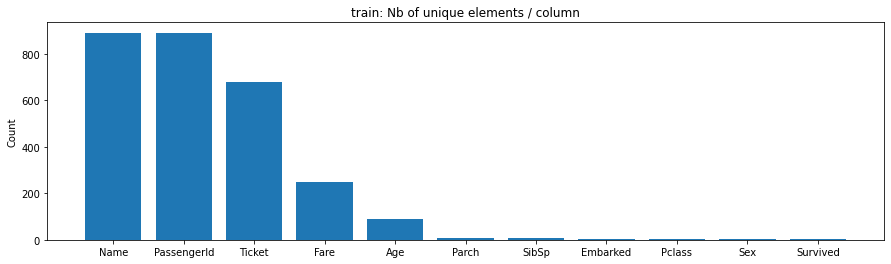



Unique element / column:


,number,percentage
Name,891,1.00
PassengerId,891,1.00
Ticket,681,0.76
Fare,248,0.28
Age,88,0.10
Parch,7,0.01
SibSp,7,0.01
Embarked,3,0.00
Pclass,3,0.00
Sex,2,0.00


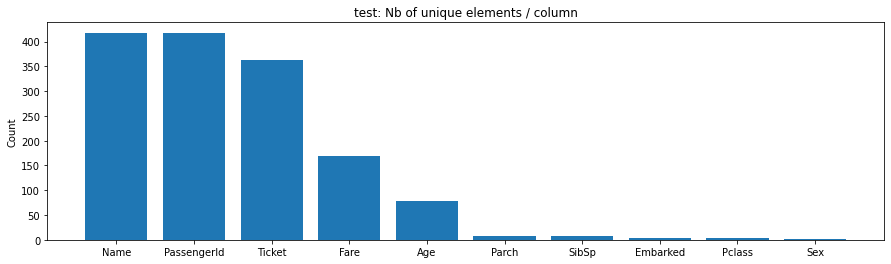



Unique element / column:


,number,percentage
Name,418,1.00
PassengerId,418,1.00
Ticket,363,0.87
Fare,169,0.40
Age,79,0.19
Parch,8,0.02
SibSp,7,0.02
Embarked,3,0.01
Pclass,3,0.01
Sex,2,0.00


In [514]:
for df in dfs:

  t = df[1].nunique().sort_values(ascending=False)

  plt.figure(figsize=(15,4))
  plt.title(f"{df[0]}: Nb of unique elements / column")
  plt.ylabel('Count')
  plt.bar(t.index, t.values)
  plt.show()

  nb = pd.Series(t, name = 'number')
  pr = pd.Series(t/len(df[1]), name = 'percentage')
  
  print('\n\nUnique element / column:')
  display(pd.concat([nb,pr], axis=1))
  print('\n\n')

**Numerical:**
- Discrete
> Parch, SibSp
- Continuous
> Fare, Age

**Categorical:**
- Nominal 
> Name, PassengerId, Ticket, Cabin, Embarked, Sex, Survived (*target*)


- Ordinal 
> Pclass

In [515]:
num_cols = ['Fare', 'Age']
num_cnt_cols = ['Parch', 'SibSp']
nominal_cols = ['Name', 'PassengerId', 'Ticket', 'Embarked', 'Sex']
ordinal_cols = ['Pclass']
target = ['Survived']

### Data distribution

#### Target

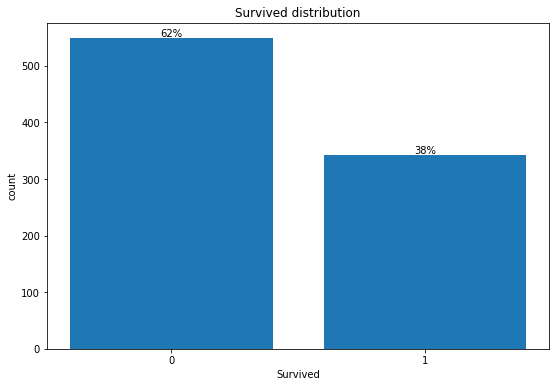

In [516]:
t = df_train['Survived'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t)
plt.ylabel('count')
plt.xlabel('Survived')
plt.title('Survived distribution')


for i in t.index:
  plt.annotate("{0:.0f}%".format(t[i]*100/len(df_train)),xy=(i, t[i]) ,ha='center', va='bottom')
plt.show()

38 % of the passenger survived

#### Numerical 

##### Distribution

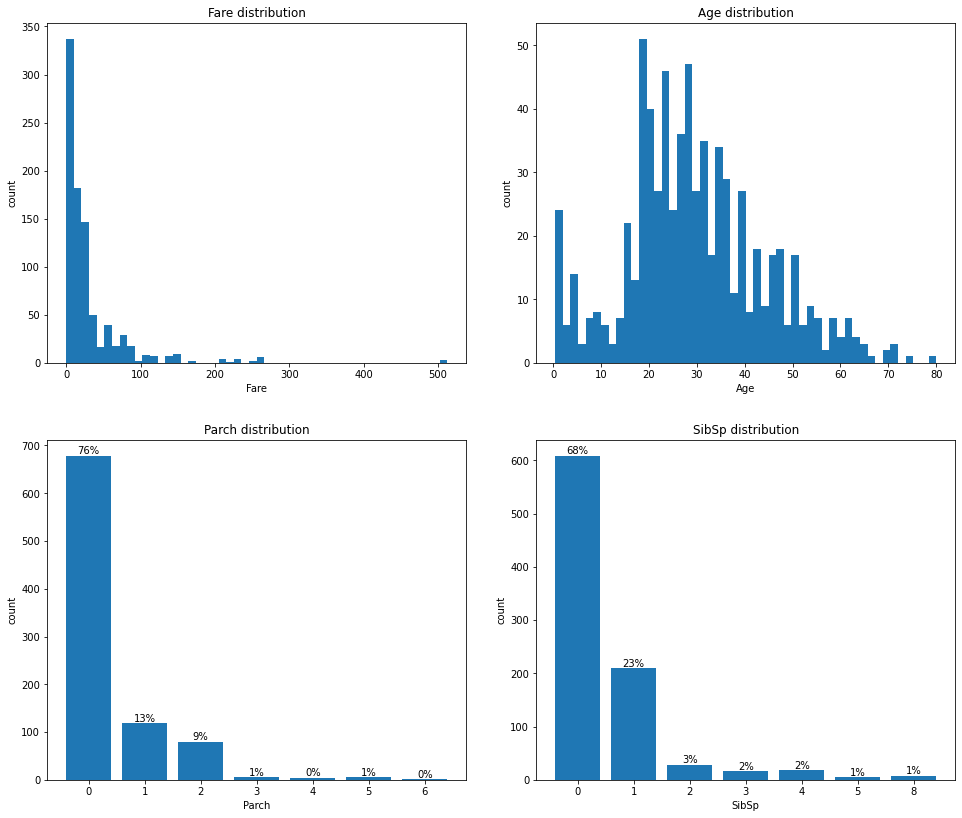

In [517]:
plt.figure(figsize=(14,12))
i=1
for col in num_cols:
  plt.subplot(2,2,i)
  plt.hist(df_train[col], bins=50)
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')  
  i+=1

for col in num_cnt_cols:
  plt.subplot(2,2,i)
  vc = df_train[col].value_counts(sort=False)

  plt.bar(vc.index.astype(str), vc)
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')

  for id in vc.index:
    plt.annotate("{0:.0f}%".format(vc[id]*100/len(df_train)),xy=(str(id), vc[id]) ,ha='center', va='bottom')

  i+=1

plt.tight_layout(pad=3)
plt.show()


In [518]:
df_train[num_cols + num_cnt_cols].describe()

,Fare,Age,Parch,SibSp
count,891.00,714.00,891.00,891.00
mean,32.20,29.70,0.38,0.52
std,49.69,14.53,0.81,1.10
min,0.00,0.42,0.00,0.00
25%,7.91,20.12,0.00,0.00
50%,14.45,28.00,0.00,0.00
75%,31.00,38.00,0.00,1.00
max,512.33,80.00,6.00,8.00


Most of passengers have 0 PARentsCHildren and 0 SIBlingSPouse => Alone

The average Age is around 30 years

##### Distribution / target

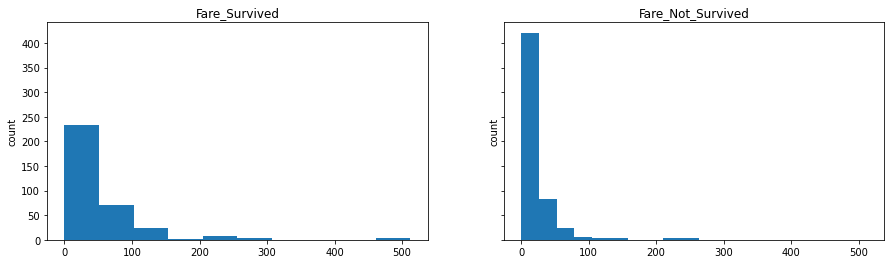

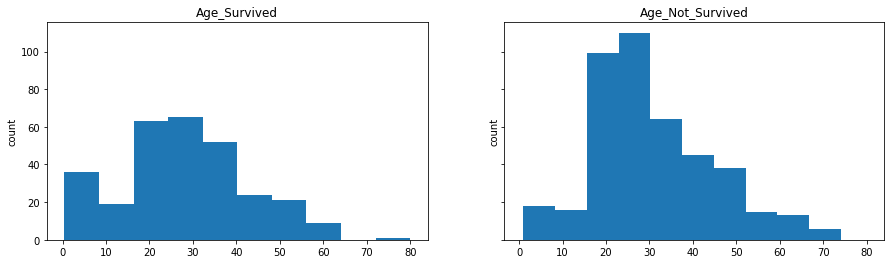

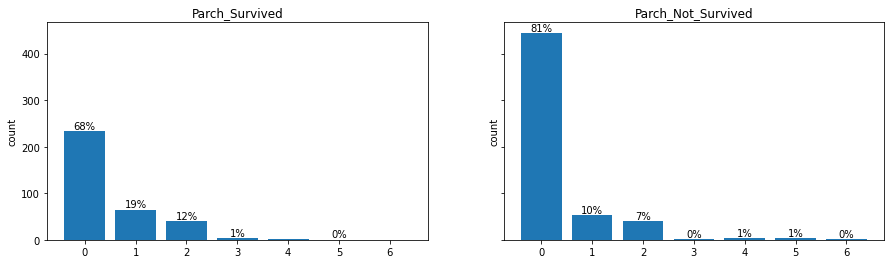

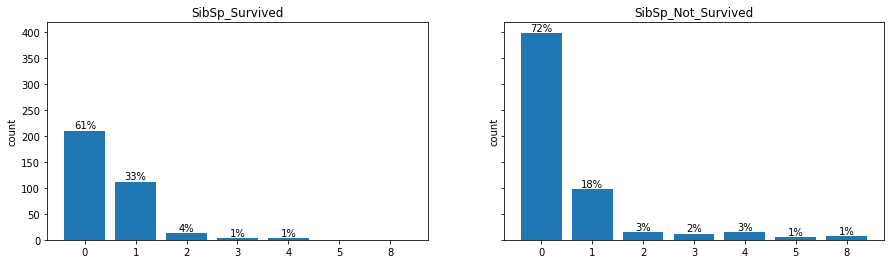

In [519]:
for col in num_cols:
  i=0
  f, sub = plt.subplots(1,2,figsize=(15,4) ,sharex=True, sharey=True)
  sub[i].hist(df_train[col].loc[df_train['Survived']==1])
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Survived')
  i+=1
  sub[i].hist(df_train[col].loc[df_train['Survived']==0])
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Not_Survived')
  i+=1


for col in num_cnt_cols:
  i=0
  f, sub = plt.subplots(1,2,figsize=(15,4) , sharex=True, sharey=True)
  vc = df_train[col].loc[df_train['Survived']==1].value_counts(sort=False)
  sub[i].bar(vc.index.astype(str),vc)
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Survived')

  for id in vc.index:
    sub[i].annotate("{0:.0f}%".format(vc[id]*100/sum(vc)),xy=(id, vc[id]) ,ha='center', va='bottom')

  i+=1

  vc = df_train[col].loc[df_train['Survived']==0].value_counts(sort=False)
  sub[i].bar(vc.index.astype(str),vc)  
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Not_Survived')

  for id in vc.index:
    sub[i].annotate("{0:.0f}%".format(vc[id]*100/sum(vc)),xy=(str(id), vc[id]) ,ha='center', va='bottom')

  i+=1

plt.show()


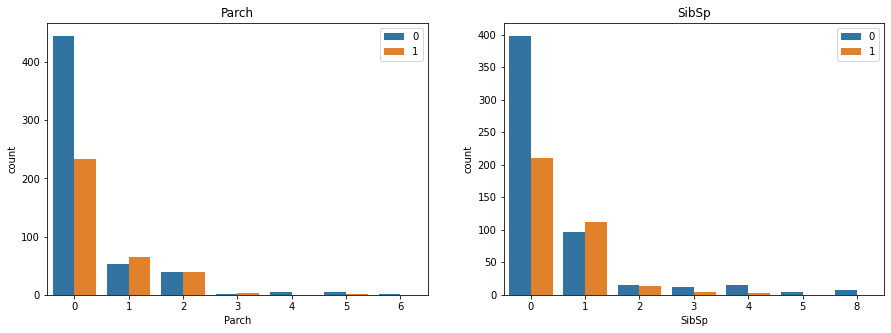

In [520]:
f,sub=plt.subplots(1,2,figsize=(15, 5))
i=0

for col in num_cnt_cols:
  sns.countplot(ax=sub[i], x= col, data = df_train, hue = 'Survived')
  sub[i].legend(loc='upper right')
  sub[i].set_title(col)
  i+=1

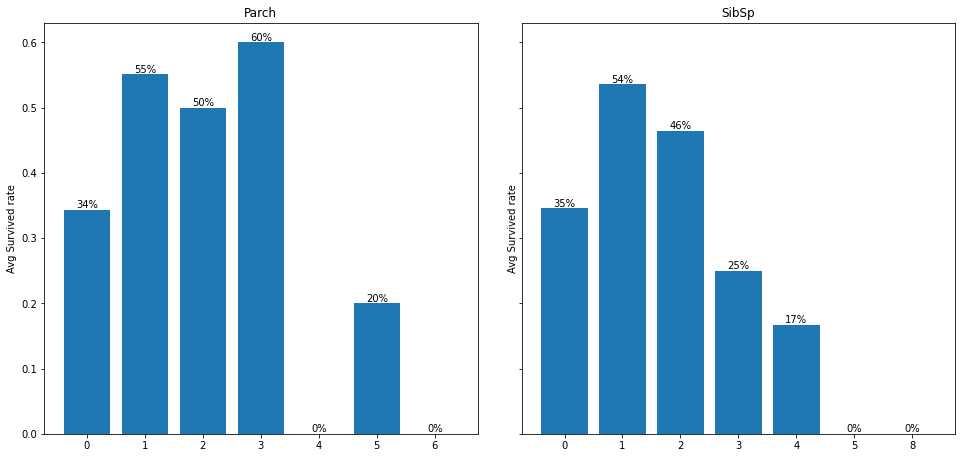

In [521]:
f,sub = plt.subplots(1,2, figsize=(14,7) ,sharey=True)
i=0
for col in num_cnt_cols:
  gp = df_train.groupby([col]).Survived.mean()
  sub[i].bar(gp.index.astype(str), gp)
  sub[i].set_ylabel('Avg Survived rate')
  sub[i].set_title(col)
  for id in gp.index:
    sub[i].annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
    ,ha='center', va='bottom')

  i+=1

plt.tight_layout(pad=3)
plt.show()

Observations:

- Lowcost passengers, Alone passenger and big famillies have the worst survival rate we will go further below using Pclass variable

- Children, old (>70) passengers  and small famillies have higher survival rate





#### Nominal

##### Overview

In [522]:
df_train[nominal_cols].describe(include='O')

,Name,Ticket,Embarked,Sex
count,891,891,891,891
unique,891,681,3,2
top,"Thorneycroft, Mrs. Percival (Florence Kate White)",1601,S,male
freq,1,7,646,577


In [523]:
df_train[['Name','Ticket']].head()

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450


From the name we can extract the title

##### Distribution

In [524]:
df_train[nominal_cols].describe(include='O')

,Name,Ticket,Embarked,Sex
count,891,891,891,891
unique,891,681,3,2
top,"Thorneycroft, Mrs. Percival (Florence Kate White)",1601,S,male
freq,1,7,646,577


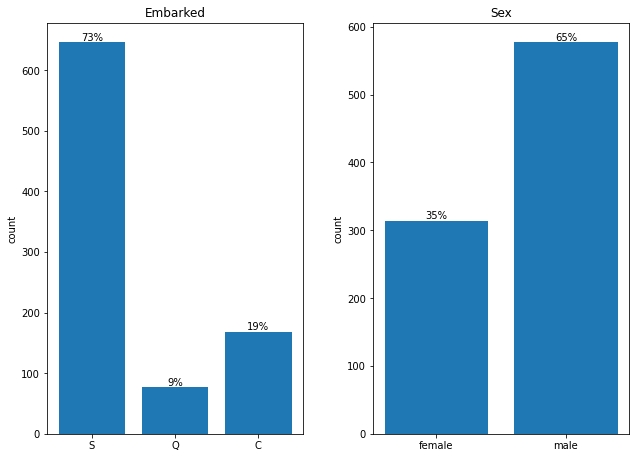

In [525]:
t = df_train[nominal_cols].nunique()<10

plt.figure(figsize=(14,7))
i=1
for col in t[t].index:
  plt.subplot(1,3,i)
  vc = df_train[col].value_counts(sort=False)

  plt.bar(vc.index, vc)
  plt.ylabel('count')
  plt.title(col)

  for id in vc.index:
    plt.annotate("{0:.0f}%".format(vc[id]*100/len(df_train)),xy=(id, vc[id]) ,ha='center', va='bottom')
  
  i+=1
plt.tight_layout(pad=3)
plt.show()

##### Distribution / target

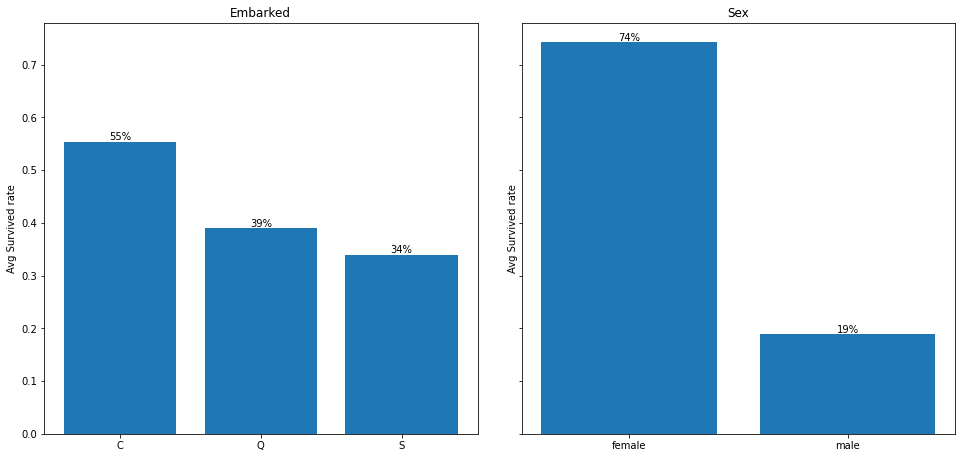

In [526]:
f, sub = plt.subplots(1,2, figsize=(14,7), sharey = True)
i=0
for col in t[t].index:
  gp = df_train.groupby([col]).Survived.mean()
  sub[i].bar(gp.index, gp)
  sub[i].set_ylabel('Avg Survived rate')
  sub[i].set_title(col)
  for id in gp.index:
    sub[i].annotate("{0:.0f}%".format(gp[id]*100),xy=(id, gp[id]) 
    ,ha='center', va='bottom')
  i+=1
plt.tight_layout(pad=3)
plt.show()


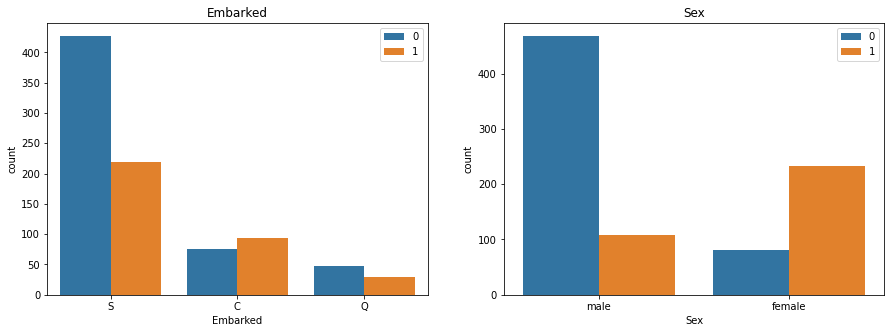

In [527]:
f,sub=plt.subplots(1,2,figsize=(15, 5))
i=0

for col in t[t].index:
  sns.countplot(ax=sub[i], x= col, data = df_train, hue = 'Survived')
  sub[i].legend(loc='upper right')
  sub[i].set_title(col)
  i+=1

Observations:

- Male passengers have a terrible survival rate (80% died) and female a great one (74% survived)
- Passengers have embarked from C have higher survival rate (55%) much better than passengers from S (34%) it may be related to the class



#### Ordinal

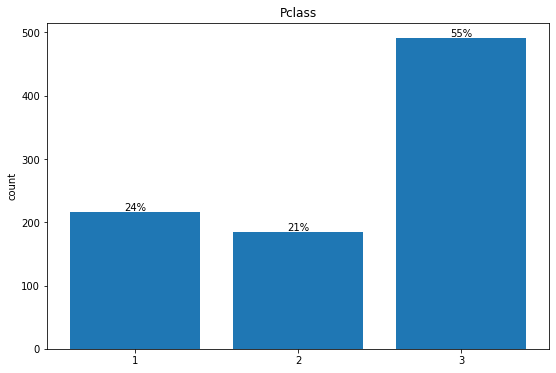

In [528]:
t = df_train['Pclass'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('Pclass')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

##### Distribution / target

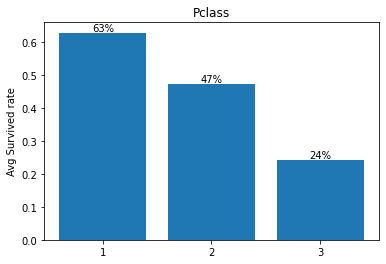

In [529]:
col='Pclass'
gp = df_train.groupby([col]).Survived.mean()
plt.bar(gp.index.astype(str), gp)
plt.ylabel('Avg Survived rate')
plt.title(col)
for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')
plt.show()

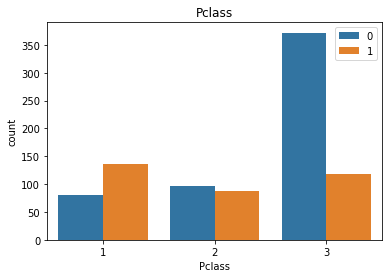

In [530]:
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

Observations:

- Better the Pclass is, greater is the survival rate. It comfirms our observation below on lowcost passenger

## Feature engineering 1


Title / Familly / Alone / Connected Survival


#### Title

In [531]:
for df in dfs:
  df[1]['Title'] = df[1]['Name'].str.extract('([A-Za-z]+)\.', expand=False)
  print(df[0],':')
  display(pd.crosstab(df[1]['Title'], df[1]['Sex']))
  print('\n\n')

train :


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40





test :


Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [532]:
for df in dfs:
  df[1]['Title'] = df[1]['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
  'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'High')
  df[1]['Title'] = df[1]['Title'].replace('Mlle', 'Miss')
  df[1]['Title'] = df[1]['Title'].replace('Ms', 'Miss')
  df[1]['Title'] = df[1]['Title'].replace('Mme', 'Mrs')

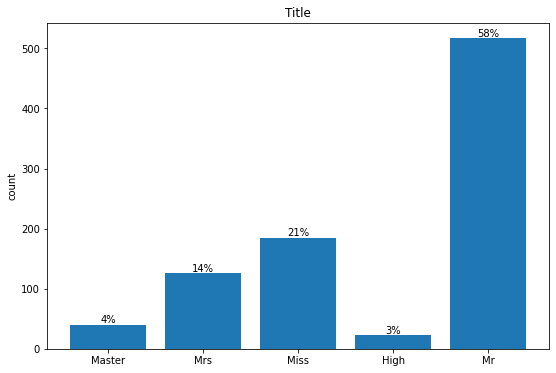

In [533]:
t = df_train['Title'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('Title')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

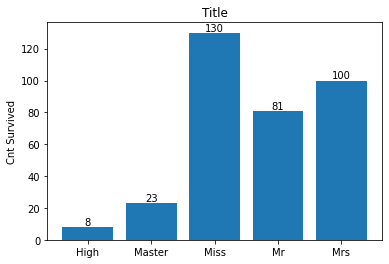

In [534]:
gp = df_train.groupby(['Title']).Survived.sum()
plt.bar(gp.index, gp)
plt.ylabel('Cnt Survived')
plt.title('Title')

for id in gp.index:
  plt.annotate("{0:.0f}".format(gp[id]),xy=(id, gp[id]) 
  ,ha='center', va='bottom')

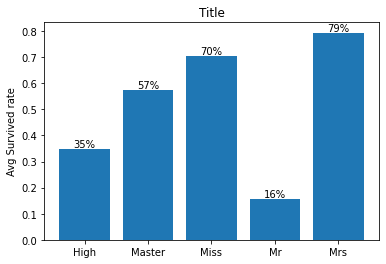

In [535]:
gp = df_train.groupby(['Title']).Survived.mean()
plt.bar(gp.index, gp)
plt.ylabel('Avg Survived rate')
plt.title('Title')

for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(id, gp[id]) 
  ,ha='center', va='bottom')

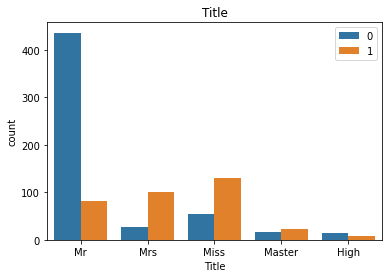

In [536]:
col='Title'
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

In [537]:
nominal_cols.append('Title')

Observations:

- Validating our previous observation female (Mrs, Miss) have much higher survival rate than male (Mr).

- Hight & Master title have higher survival rate than Mr and a lower than female (Mrs, Miss)

#### Familly

In [538]:
# error this passenger traveled alone
df_train.loc[273, 'Parch'] = 0

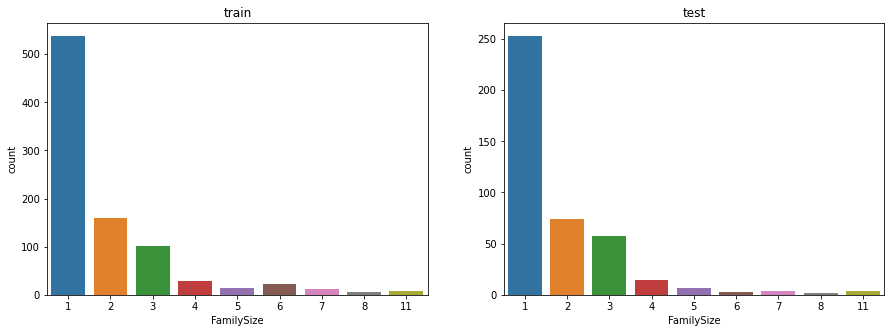

In [539]:
f,sub=plt.subplots(1,2,figsize=(15, 5))
i=0

for df in dfs:
  df[1]['FamilySize'] = df[1]['SibSp'] + df[1]['Parch'] +1
  sns.countplot(ax=sub[i], x= 'FamilySize',data =df[1])
  sub[i].set_title(df[0])
  i+=1


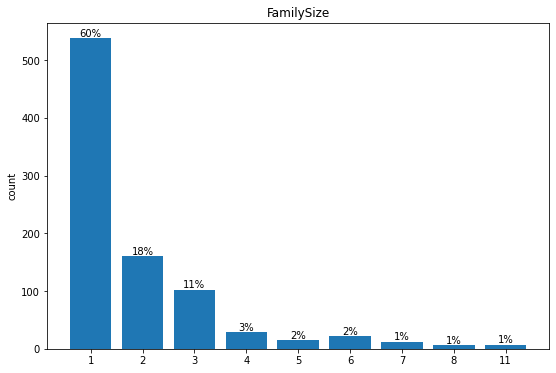

In [540]:
t = df_train['FamilySize'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('FamilySize')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

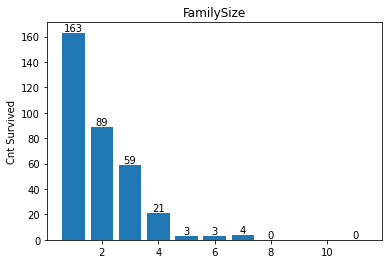

In [541]:
gp = df_train.groupby(['FamilySize']).Survived.sum()
plt.bar(gp.index, gp)
plt.ylabel('Cnt Survived')
plt.title('FamilySize')

for id in gp.index:
  plt.annotate("{0:.0f}".format(gp[id]),xy=(id, gp[id]) 
  ,ha='center', va='bottom')

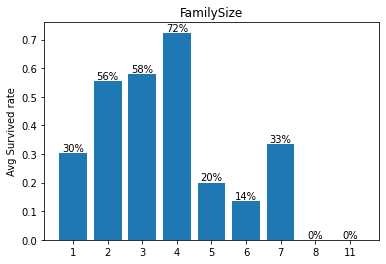

In [542]:
gp = df_train.groupby(['FamilySize']).Survived.mean()
plt.bar(gp.index.astype('str'), gp)
plt.ylabel('Avg Survived rate')
plt.title('FamilySize')

for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')

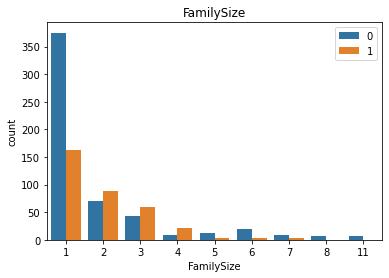

In [543]:
col='FamilySize'
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

Observations:

- The survival rate increase with the familly size until 4 and decrease after

#### Alone

train :


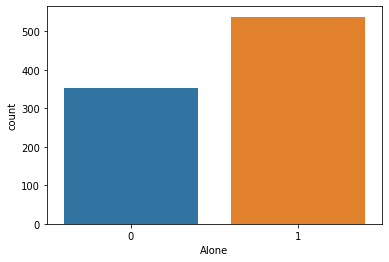




test :


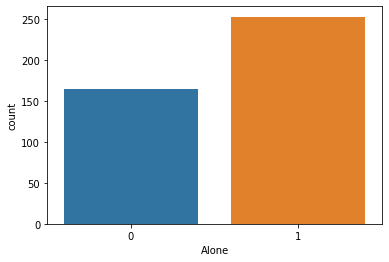

In [544]:
for df in dfs:
  df[1]['Alone'] = 0
  df[1].loc[df[1]['FamilySize']==1, 'Alone' ] = 1
  print(df[0],':')
  sns.countplot(df[1]['Alone'])
  plt.show()
  print('\n\n')

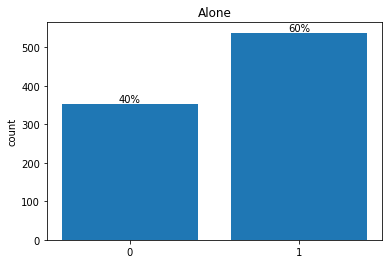

In [545]:
t = df_train['Alone'].value_counts(sort=False)

plt.figure(figsize=(6,4))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('Alone')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

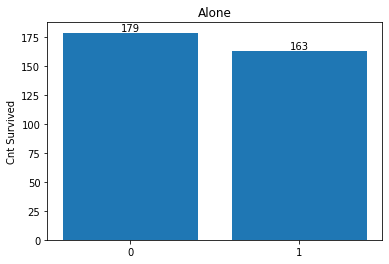

In [546]:
gp = df_train.groupby(['Alone']).Survived.sum()
plt.bar(gp.index.astype('str'), gp)
plt.ylabel('Cnt Survived')
plt.title('Alone')

for id in gp.index:
  plt.annotate("{0:.0f}".format(gp[id]),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')

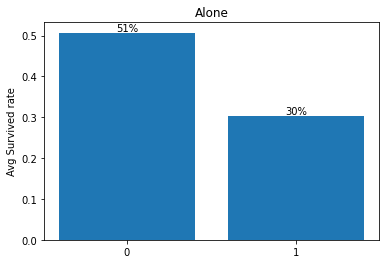

In [547]:
gp = df_train.groupby(['Alone']).Survived.mean()
plt.bar(gp.index.astype('str'), gp)
plt.ylabel('Avg Survived rate')
plt.title('Alone')

for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')

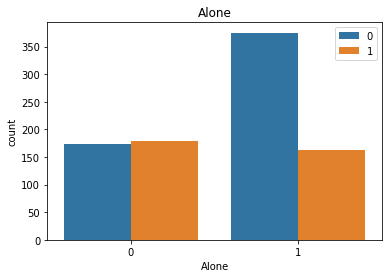

In [548]:
col='Alone'
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

Observations:

- The survival rate is lower for alone passenger

#### Last Name

In [549]:
for df in dfs:
  df[1]['Last_Name'] = df[1]['Name'].apply(lambda x: str.split(x, ",")[0])

In [550]:
df_train.sort_values('Name').head(10)

,PassengerId,Survived,Pclass,Name,Sex,...,Embarked,Title,FamilySize,Alone,Last_Name
845,846,0,3,"Abbing, Mr. Anthony",male,...,S,Mr,1,1,Abbing
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,S,Mr,3,0,Abbott
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,S,Mrs,3,0,Abbott
308,309,0,2,"Abelson, Mr. Samuel",male,...,C,Mr,2,0,Abelson
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,...,C,Mrs,2,0,Abelson
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,...,S,Mr,1,1,Adahl
401,402,0,3,"Adams, Mr. John",male,...,S,Mr,1,1,Adams
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,...,S,Mrs,2,0,Ahlin
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,...,S,Mrs,2,0,Aks
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,...,C,Mr,1,1,Albimona


#### Familly id


We will try to group famillies


In [551]:
df_test['Survived'] = 9

In [552]:
df_full = pd.concat([df_train, df_test], axis = 0).sort_values('Name').reset_index(drop=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,...,Embarked,Title,FamilySize,Alone,Last_Name
0,846,0,3,"Abbing, Mr. Anthony",male,...,S,Mr,1,1,Abbing
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,S,Master,3,0,Abbott
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,S,Mr,3,0,Abbott
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,S,Mrs,3,0,Abbott
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,...,S,Miss,1,1,Abelseth


##### Group by ticket / Familly size

People with the same ticket and the same family size are supposed to be in the same family

In [553]:
df_sub_full = df_full[['PassengerId', 'FamilySize', 'Alone', 'Ticket']]
gb_Tick_FamSize = df_sub_full.loc[df_sub_full['Alone'] == 0].groupby(['Ticket','FamilySize']).count()
gb_Tick_FamSize.head()

,,PassengerId,Alone
Ticket,FamilySize,,
110413,3,3,3
110813,2,2,2
111361,2,2,2
112378,2,2,2
112901,3,1,1


In [554]:
gb_Tick_FamSize.reset_index(inplace=True)
gb_Tick_FamSize.drop(['Alone'], axis =1, inplace=True )
gb_Tick_FamSize.rename(columns={'PassengerId':'CntPassengerId'}, inplace=True)
gb_Tick_FamSize = pd.DataFrame(gb_Tick_FamSize)

In [555]:
# Families where the group by count = Family size
fam_id_table = gb_Tick_FamSize.loc[gb_Tick_FamSize['FamilySize'] == gb_Tick_FamSize['CntPassengerId']]
fam_id_table['Familly_id'] = np.arange(1,len(fam_id_table)+1)
fam_id_table.head()

,Ticket,FamilySize,CntPassengerId,Familly_id
0,110413,3,3,1
1,110813,2,2,2
2,111361,2,2,3
3,112378,2,2,4
5,113503,3,3,5


**We will join the 2 tables**

In [556]:
df_full = df_full.merge(fam_id_table, how='left' ,on=['Ticket', 'FamilySize'])
df_full.drop('CntPassengerId', axis=1, inplace=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,...,Title,FamilySize,Alone,Last_Name,Familly_id
0,846,0,3,"Abbing, Mr. Anthony",male,...,Mr,1,1,Abbing,nan
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,Master,3,0,Abbott,114.00
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,Mr,3,0,Abbott,114.00
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,Mrs,3,0,Abbott,114.00
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,...,Miss,1,1,Abelseth,nan


##### Group by Last_Name / Familly size / Pclass

People with the same last name, familly size and Pclass are supposed to be in the same family

In [557]:
df_sub_full = df_full[['PassengerId', 'FamilySize', 'Alone','Last_Name','Pclass' ,'Familly_id']]
gb_LastName_FamSize_PCl = df_sub_full.loc[(df_sub_full['Alone'] == 0) & (df_sub_full['Familly_id'].isnull())].groupby(['Last_Name', 'FamilySize', 'Pclass']).count()
gb_LastName_FamSize_PCl.reset_index(inplace=True)
gb_LastName_FamSize_PCl.drop(['Alone', 'Familly_id'], axis =1, inplace=True)
gb_LastName_FamSize_PCl.rename(columns={'PassengerId':'CntPassengerId'}, inplace=True)

In [558]:
# Families where the group by count = Family size
fam_id_table_2 = gb_LastName_FamSize_PCl.loc[gb_LastName_FamSize_PCl['FamilySize'] == gb_LastName_FamSize_PCl['CntPassengerId']]
fam_id_table_2['Familly_id'] = np.arange(len(fam_id_table)+1, len(fam_id_table)+ len(fam_id_table_2)+1)
fam_id_table_2.head()

,Last_Name,FamilySize,Pclass,CntPassengerId,Familly_id
7,Bourke,3,3,3,153
8,Braund,2,3,2,154
12,Crosby,3,1,3,155
15,Davies,3,3,3,156
17,Duff Gordon,2,1,2,157


In [559]:
df_full = df_full.merge(fam_id_table_2, how='left' ,on=['Last_Name', 'FamilySize', 'Pclass'])
df_full.drop('CntPassengerId', axis=1, inplace=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,...,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
0,846,0,3,"Abbing, Mr. Anthony",male,...,1,1,Abbing,nan,nan
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,3,0,Abbott,114.00,nan
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,3,0,Abbott,114.00,nan
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,3,0,Abbott,114.00,nan
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,...,1,1,Abelseth,nan,nan


In [560]:
df_full.loc[(df_full.Familly_id_y.notnull()) | (df_full.Familly_id_x.notnull())].head()

,PassengerId,Survived,Pclass,Name,Sex,...,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,3,0,Abbott,114.00,nan
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,3,0,Abbott,114.00,nan
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,3,0,Abbott,114.00,nan
6,309,0,2,"Abelson, Mr. Samuel",male,...,2,0,Abelson,122.00,nan
7,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,...,2,0,Abelson,122.00,nan


In [561]:
df_full.loc[(df_full.Alone == 0)].head()

,PassengerId,Survived,Pclass,Name,Sex,...,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,3,0,Abbott,114.00,nan
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,3,0,Abbott,114.00,nan
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,3,0,Abbott,114.00,nan
6,309,0,2,"Abelson, Mr. Samuel",male,...,2,0,Abelson,122.00,nan
7,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,...,2,0,Abelson,122.00,nan


In [562]:
sub = df_full.loc[(df_full.Alone == 0)]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull())].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
12,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.47,S,Mrs,2,0,Ahlin,nan,nan
29,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.00,1,0,350046,7.85,S,Miss,2,0,Andersen-Jensen,nan,nan
34,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.92,S,Miss,7,0,Andersson,nan,nan
35,1106,9,3,"Andersson, Miss. Ida Augusta Margareta",female,38.00,4,2,347091,7.78,S,Miss,7,0,Andersson,nan,nan
50,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.48,S,Mrs,3,0,Appleton,nan,nan


For this 65 people I will do manual search on internet

##### MANUAL SEARCH

In [563]:
cnt_fam_id = len(fam_id_table)+ len(fam_id_table_2)
cnt_fam_id

171

In [564]:
df_full.loc[ (df_full['Last_Name'] == 'Ahlin') | (df_full['Last_Name'] == 'Petterson'), 'Familly_id_z' ] = cnt_fam_id
cnt_fam_id += 1

In [565]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Andersen-Jensen') | (df_full['Last_Name'] == 'Jensen')]
idx = sub.loc[sub['Alone']!= 1].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [566]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Andersson') | (df_full['Last_Name'] == 'Backstrom') | (df_full['Last_Name'] == 'Gustafsson')]
sub = sub.loc[sub['Alone']!= 1]
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [567]:
sub = df_full.loc[(df_full['Last_Name'] == 'Appleton') | (df_full['Last_Name'] == 'Brown')  | (df_full['Last_Name'] == 'Cornell') ] 
sub = sub.loc[sub['Alone']!= 1]
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [568]:
df_full.loc[ (df_full['Last_Name'] == 'Beckwith') | (df_full['Last_Name'] == 'Newsom'), 'Familly_id_z' ] = cnt_fam_id
cnt_fam_id += 1

In [569]:
df_full.loc[ (df_full['Last_Name'] == 'Christy') | (df_full['Last_Name'] == 'Jacobsohn'), 'Familly_id_z' ] = cnt_fam_id
cnt_fam_id += 1

In [570]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Davidson') | (df_full['Last_Name'] == 'Hays')]
sub = sub.loc[sub['Alone']!= 1]
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [571]:
df_full.loc[ (df_full['Ticket'] == 'PC 17558') & (df_full['Alone'] == 0) & (df_full['Familly_id_x'].isnull()), 'Familly_id_x'] =124

In [572]:
df_full.loc[ (df_full['Last_Name'] == 'Frauenthal') & (df_full['Alone'] == 0) & (df_full['Familly_id_y'].isnull()), 'Familly_id_y'] = 160

In [573]:
df_full.loc[ (df_full['Last_Name'] == 'Frolicher-Stehli') | (df_full['Last_Name'] == 'Frolicher'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [574]:
df_full.loc[ (df_full['Last_Name'] == 'Hiltunen') |  (df_full['Last_Name'] == 'Hamalainen'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [575]:
df_full.loc[ (df_full['Last_Name'] == 'Hansen')& (df_full['Alone'] == 0), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [576]:
df_full.loc[ (df_full['Last_Name'] == 'Hirvonen') | (df_full['Last_Name'] == 'Lindqvist'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [577]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Hocking') | (df_full['Last_Name'] == 'Richards')| (df_full['Last_Name'] == 'Wilkes') ]
idx = sub.loc[sub['Alone']==0].index
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [578]:
df_full.loc[ (df_full['Last_Name'] == 'Jefferys') | (df_full['Last_Name'] == 'Renouf'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [579]:
df_full.loc[ (df_full['Last_Name'] == 'Kink') | (df_full['Last_Name'] == 'Kink-Heilmann'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [580]:
df_full.loc[ (df_full['Last_Name'] == 'Lahtinen') | (df_full['Last_Name'] == 'Silven') , 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [581]:
df_full.loc[ (df_full['Last_Name'] == 'Minahan'), 'Familly_id_x'] = 32


In [582]:
df_full.loc[ (df_full['Last_Name'] == 'Newell'), 'Familly_id_x'] = 90

In [583]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Persson') | (df_full['Last_Name'] == 'Strom') ]
idx = sub.loc[sub['Alone']==0].index
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [584]:
df_full.loc[ (df_full['Last_Name'] == 'Thomas')& (df_full['Alone'] == 0), 'Familly_id_y'] = 169

In [585]:
df_full.loc[ (df_full['Last_Name'] == 'Vander Planke')& (df_full['Alone'] == 0) , 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

##### VERIF

In [586]:
sub = df_full.loc[(df_full.Alone == 0)]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z


In [587]:
len(sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())])

0

In [588]:
df_full.loc[ (df_full['Last_Name'] == 'Natsch')& (df_full['Alone'] == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z


##### OUT

In [589]:
df_full['Familly_id'] = df_full[['Familly_id_x','Familly_id_y','Familly_id_z']].fillna(0).apply(sum, axis=1)

In [590]:
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,Mr,1,1,Abbing,nan,nan,nan,0.00
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,Master,3,0,Abbott,114.00,nan,nan,114.00
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.25,S,Mr,3,0,Abbott,114.00,nan,nan,114.00
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.25,S,Mrs,3,0,Abbott,114.00,nan,nan,114.00
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,16.00,0,0,348125,7.65,S,Miss,1,1,Abelseth,nan,nan,nan,0.00


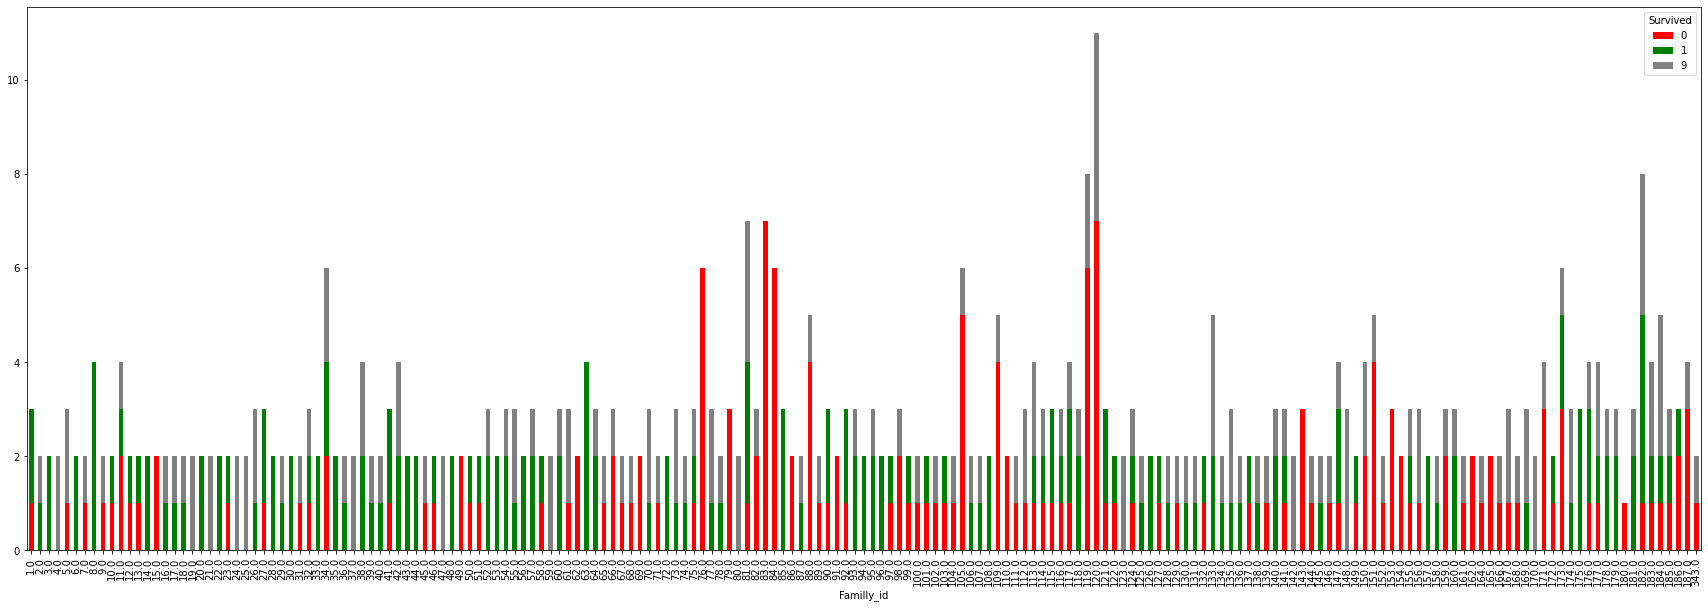

In [591]:
pd.crosstab(df_full['Familly_id'], df_full['Survived']).drop([0]).plot(kind='bar', stacked=True, color=['r','g','grey'], figsize=(30,10))
plt.show()

We can see that famillies are a group they all die or all survived exception for couple

#### Couple

In [592]:
df_full.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,Mr,1,1,Abbing,nan,nan,nan,0.00
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,Master,3,0,Abbott,114.00,nan,nan,114.00


In [593]:
df_full['group_size'] = df_full.groupby(['Familly_id']).PassengerId.transform('count')
df_full.loc[df_full['group_size']==790, 'group_size'] = 0

In [594]:
d_sex = {'male':1, 'female' : 0}
df_full['Sex'] = df_full['Sex'].map(d_sex)
# df_full.loc[df_full['group_size']==2].groupby(['Familly_id']).Sex.sum()

In [595]:
df_full['grp_cnt_male'] = df_full.groupby(['Familly_id']).Sex.transform('sum')

In [596]:
df_full.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id,group_size,grp_cnt_male
0,846,0,3,"Abbing, Mr. Anthony",1,42.00,0,0,C.A. 5547,7.55,S,Mr,1,1,Abbing,nan,nan,nan,0.00,0,596
1,1284,9,3,"Abbott, Master. Eugene Joseph",1,13.00,0,2,C.A. 2673,20.25,S,Master,3,0,Abbott,114.00,nan,nan,114.00,3,2


In [597]:
df_full['Couple'] = 0

In [598]:
df_full.loc[ (df_full['group_size'] == 2) & (df_full['grp_cnt_male'] == 1) & (df_full['SibSp'] == 1), 'Couple'] = 1

In [599]:
couple = df_full.loc[df_full['Couple'] == 1 ]

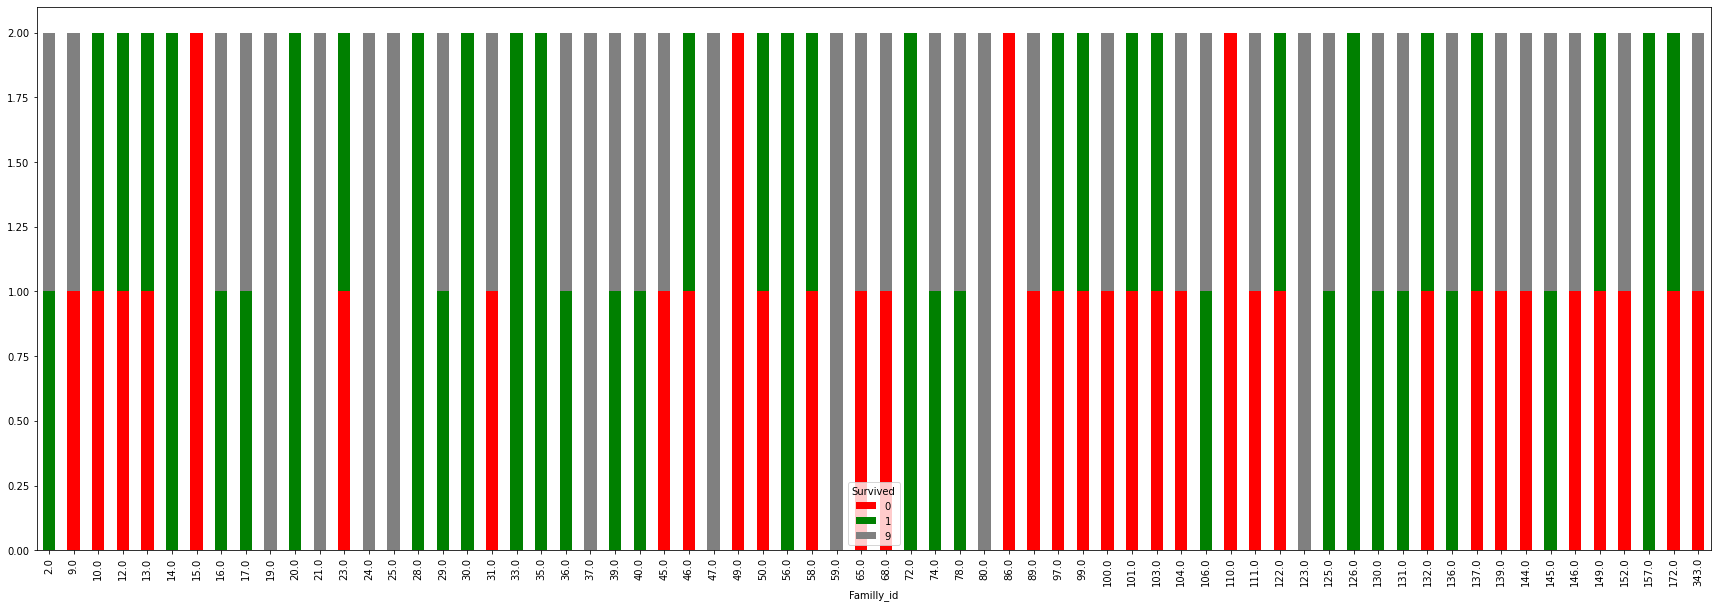

In [600]:
pd.crosstab(couple['Familly_id'], couple['Survived']).plot(kind='bar', stacked=True, color=['r','g','grey'], figsize=(30,10))
plt.show()

### Data correlation

In [601]:
# d_sex = {'male':1, 'female' : 0}
# for df in dfs:
#   df[1]['Sex'] = df[1]['Sex'].map(d_sex)

In [602]:
# mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))

In [603]:
# plt.figure(figsize=(12,6))
# sns.heatmap(df_train.corr(),mask=mask ,annot = True, fmt = '.2f')
# plt.show()

## Fill NAn

#### Fare

We saw there is only one passenger with missing Fare value in test set. 

According to correlation graph, Fare is corralated to family size (Parch and SibSp), Sex and Pclass features. 

Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [604]:
df_full.groupby(['Pclass','Sex' ,'Parch', 'SibSp']).Fare.median()[3][1][0][0]

7.8875

In [605]:
med_fare = df_full.groupby(['Pclass','Sex' ,'Parch', 'SibSp']).Fare.median()[3][1][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_full.loc[(df_full['Fare'].isnull()) & (df_full['Survived']==9),'Fare'] = med_fare

#### Age


We will use a model to predict missing Age

In [606]:
df_full = df_full.sort_values(by='PassengerId').reset_index(drop=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id,group_size,grp_cnt_male,Couple
0,1,0,3,"Braund, Mr. Owen Harris",1,22.00,1,0,A/5 21171,7.25,S,Mr,2,0,Braund,nan,154.00,nan,154.00,2,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00,1,0,PC 17599,71.28,C,Mrs,2,0,Cumings,130.00,nan,nan,130.00,2,1,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.00,0,0,STON/O2. 3101282,7.92,S,Miss,1,1,Heikkinen,nan,nan,nan,0.00,0,596,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00,1,0,113803,53.10,S,Mrs,2,0,Futrelle,13.00,nan,nan,13.00,2,1,1
4,5,0,3,"Allen, Mr. William Henry",1,35.00,0,0,373450,8.05,S,Mr,1,1,Allen,nan,nan,nan,0.00,0,596,0


In [607]:
df_train_test = df_full.copy()
df_train_test.drop(['Name', 'Last_Name', 'Ticket', 'Familly_id_x', 'Familly_id_y', 'Familly_id_z', 'FamilySize' ,'grp_cnt_male'], axis =1, inplace = True)
df_train_test

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Alone,Familly_id,group_size,Couple
0,1,0,3,1,22.00,1,0,7.25,S,Mr,0,154.00,2,0
1,2,1,1,0,38.00,1,0,71.28,C,Mrs,0,130.00,2,1
2,3,1,3,0,26.00,0,0,7.92,S,Miss,1,0.00,0,0
3,4,1,1,0,35.00,1,0,53.10,S,Mrs,0,13.00,2,1
4,5,0,3,1,35.00,0,0,8.05,S,Mr,1,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,9,3,1,nan,0,0,8.05,S,Mr,1,0.00,0,0
1305,1306,9,1,0,39.00,0,0,108.90,C,High,1,0.00,0,0
1306,1307,9,3,1,38.50,0,0,7.25,S,Mr,1,0.00,0,0
1307,1308,9,3,1,nan,0,0,8.05,S,Mr,1,0.00,0,0


### Encoding

Feature to encode: 
- Sex (binary)
- Embarked (OHE)
- Title (OHE)

In [608]:
# Sex
# d_sex = {'male':1, 'female' : 0}
# df_train_test['Sex'] = df_train_test['Sex'].map(d_sex)

In [609]:
# Embarked, Title
df_train_test = pd.get_dummies(df_train_test, columns=['Embarked', 'Title'])
df_train_test.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,Familly_id,group_size,Couple,Embarked_C,Embarked_Q,Embarked_S,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,1,22.00,1,0,7.25,0,154.00,2,0,0,0,1,0,0,0,1,0
1,2,1,1,0,38.00,1,0,71.28,0,130.00,2,1,1,0,0,0,0,0,0,1
2,3,1,3,0,26.00,0,0,7.92,1,0.00,0,0,0,0,1,0,0,1,0,0
3,4,1,1,0,35.00,1,0,53.10,0,13.00,2,1,0,0,1,0,0,0,0,1
4,5,0,3,1,35.00,0,0,8.05,1,0.00,0,0,0,0,1,0,0,0,1,0


In [610]:
col_to_add_after_training = ['Survived', 'Familly_id','PassengerId', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
add_columns_train_test = df_train_test[col_to_add_after_training]

In [611]:
# we drop survived bc of Nan and Familly_id
df_train_test.drop(col_to_add_after_training, axis=1,inplace=True)
df_train_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,nan,0,0,8.05,1,0,0,0,0,0,1,0
1305,1,0,39.00,0,0,108.90,1,0,0,1,0,0,0,0
1306,3,1,38.50,0,0,7.25,1,0,0,0,0,0,1,0
1307,3,1,nan,0,0,8.05,1,0,0,0,0,0,1,0


In [612]:
df_age_null = df_train_test.loc[df_train_test.Age.isnull()]

In [613]:
df_age_notnull = df_train_test.loc[df_train_test.Age.notnull()]

X = df_age_notnull.drop('Age', axis=1)
y = df_age_notnull['Age']

In [614]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X, y, random_state=42)

In [615]:
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_age_train, X_age_test, y_age_train, y_age_test)
print(models)

100%|██████████| 42/42 [00:04<00:00,  9.03it/s]

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
GradientBoostingRegressor                    0.42       0.45    9.76   
MLPRegressor                                 0.40       0.43    9.88   
SVR                                          0.39       0.42   10.02   
HistGradientBoostingRegressor                0.38       0.41   10.06   
LGBMRegressor                                0.37       0.40   10.14   
LinearSVR                                    0.36       0.39   10.25   
NuSVR                                        0.36       0.39   10.27   
Lasso                                        0.35       0.38   10.32   
LarsCV                                       0.35       0.38   10.35   
LassoLarsIC                                  0.34       0.38   10.38   
PoissonRegressor                             0.34       0.37   10.40   
HuberRegressor                               0.34       0.37   1

In [616]:

reg = GradientBoostingRegressor(random_state=42)
reg.fit(X, y)
y_pred_age = reg.predict(df_age_null.drop('Age', axis=1))

In [617]:
sorted(list(zip(X.columns,reg.feature_importances_)), key=lambda x : x[1], reverse = True)

[('Pclass', 0.2875237075556218),
 ('Title_Master', 0.22308304933036294),
 ('Title_Miss', 0.18876610581152578),
 ('Fare', 0.12578727577969293),
 ('Parch', 0.07597726791742207),
 ('group_size', 0.031715938077858045),
 ('SibSp', 0.020654143919620067),
 ('Title_Mrs', 0.019772061769482752),
 ('Title_High', 0.011331929875531917),
 ('Couple', 0.011230777637127936),
 ('Title_Mr', 0.0031612664439292478),
 ('Sex', 0.0008108349957762699),
 ('Alone', 0.000185640886048369)]

In [618]:
df_age_null.Age = y_pred_age

In [619]:
df_full = pd.concat([df_age_notnull,df_age_null], axis = 0).sort_index()
df_full = pd.concat([df_full,add_columns_train_test], axis=1)

In [620]:
# df_train = df_full.iloc[:len(df_train)]
# df_test = df_full.iloc[len(df_train):]

In [621]:
df_full

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Familly_id,PassengerId,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,154.00,1,0,0,1
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,130.00,2,1,0,0
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0.00,3,0,0,1
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,13.00,4,0,0,1
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0.00,5,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,28.56,0,0,8.05,1,0,0,0,0,0,1,0,9,0.00,1305,0,0,1
1305,1,0,39.00,0,0,108.90,1,0,0,1,0,0,0,0,9,0.00,1306,1,0,0
1306,3,1,38.50,0,0,7.25,1,0,0,0,0,0,1,0,9,0.00,1307,0,0,1
1307,3,1,28.56,0,0,8.05,1,0,0,0,0,0,1,0,9,0.00,1308,0,0,1


## Feature engineering 2


#### Family with children

In [622]:
df_full['Familly_wt_chld'] = df_full.groupby(['Familly_id']).Age.transform('min')
df_full['Familly_wt_chld'].loc[df_full['Familly_wt_chld']<17] = 1
df_full['Familly_wt_chld'].loc[df_full['Familly_wt_chld']>=17] = 0
df_full.loc[(df_full['Alone'] == 1), 'Familly_wt_chld'] = 0
df_full.loc[(df_full['Couple'] == 1), 'Familly_wt_chld'] = 0

In [623]:
df_full.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Familly_id,PassengerId,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,154.00,1,0,0,1,0.00
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,130.00,2,1,0,0,0.00
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0.00,3,0,0,1,0.00
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,13.00,4,0,0,1,0.00
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0.00,5,0,0,1,0.00


In [624]:
chld = df_full.loc[df_full['Familly_wt_chld'] == 1 ]

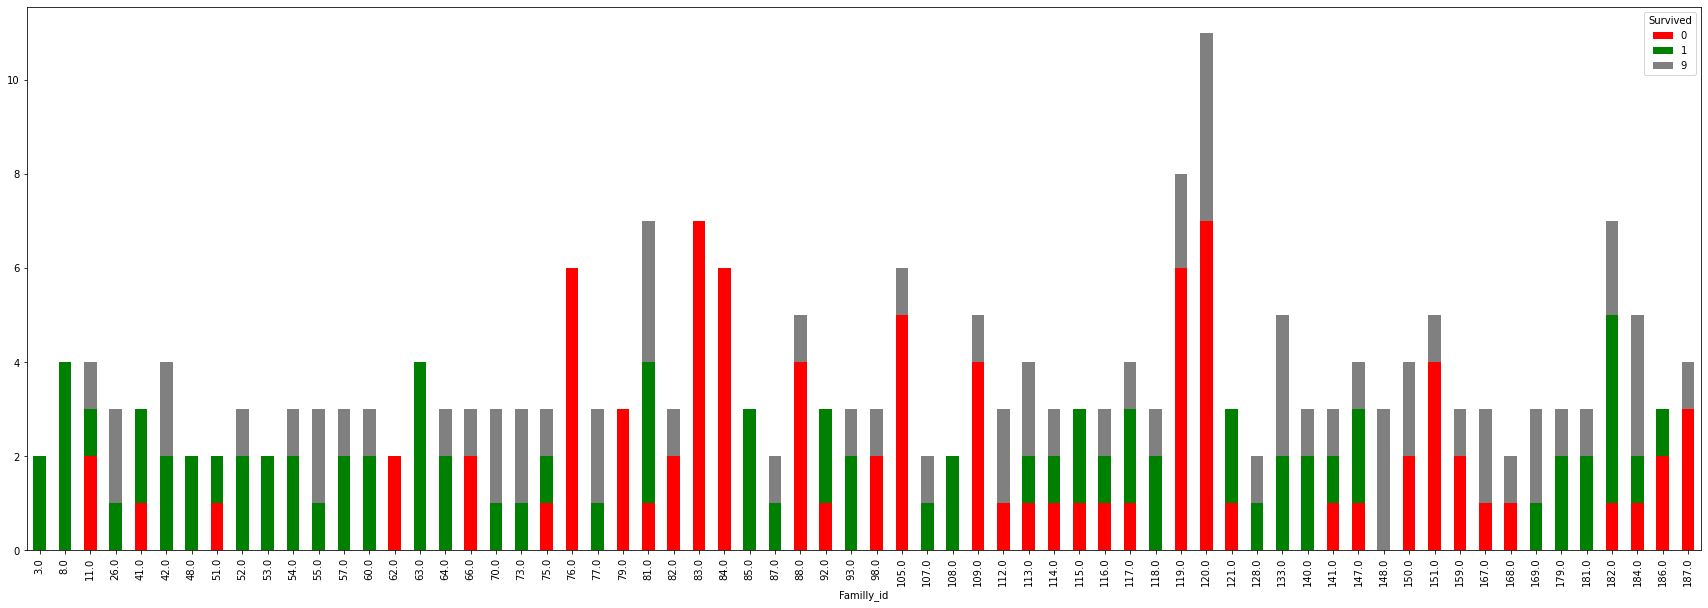

In [625]:
pd.crosstab(chld['Familly_id'], chld['Survived']).plot(kind='bar', stacked=True, color=['r','g','grey'], figsize=(30,10))
plt.show()

Big familly (up to 4 people) => more likely to all died maybe they want to stay together

Small familly tend to all survived or just the men died

#### Connected survival


In [626]:
df_full['Connected_Survival'] = df_full.groupby(['Familly_id'])['Survived'].transform('median')

In [627]:
df_full.loc[df_full['Alone']==1, 'Connected_Survival'] = 0.5
df_full.loc[df_full['Connected_Survival']== 5 , 'Connected_Survival'] = 0.5
df_full.loc[df_full['Connected_Survival']== 4.5, 'Connected_Survival'] = 0.5
df_full.loc[df_full['Connected_Survival']== 9, 'Connected_Survival'] = 0.5

In [628]:
df_full['Connected_Survival'].value_counts()

0.50    1027
1.00     170
0.00     112
Name: Connected_Survival, dtype: int64

In [629]:
df_full.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Familly_id,PassengerId,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld,Connected_Survival
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,154.00,1,0,0,1,0.00,0.00
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,130.00,2,1,0,0,0.00,0.50
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0.00,3,0,0,1,0.00,0.50
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,13.00,4,0,0,1,0.00,0.50
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0.00,5,0,0,1,0.00,0.50


In [630]:
df_full.iloc[:len(df_train)].drop(['Familly_id', 'PassengerId'], axis = 1).head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld,Connected_Survival
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,0,0,1,0.00,0.00
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,1,0,0,0.00,0.50
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0,0,1,0.00,0.50
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,0,0,1,0.00,0.50
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0,0,1,0.00,0.50


In [631]:
# df_train = df_full.iloc[:len(df_train)].drop(['Familly_id', 'PassengerId', 'SibSp', 'Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S'], axis = 1)
# df_test = df_full.iloc[len(df_train):].drop(['Familly_id', 'PassengerId', 'SibSp', 'Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S'], axis = 1)

df_train = df_full.iloc[:len(df_train)].drop(['Familly_id', 'PassengerId'], axis = 1)
df_test = df_full.iloc[len(df_train):].drop(['Familly_id', 'PassengerId'], axis = 1)

## Modeling

### Preprocessing

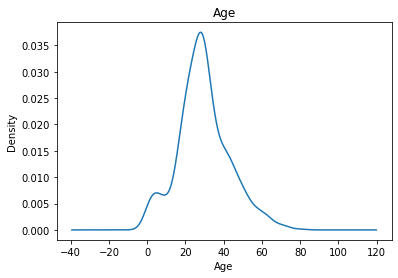

In [632]:
df_train.Age.plot(kind='kde')
plt.title('Age')
plt.xlabel('Age')
plt.show()

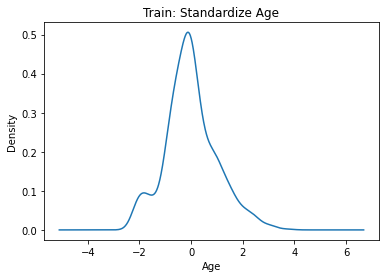

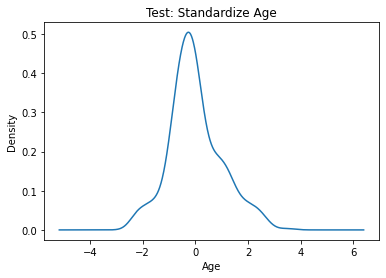

In [633]:
scaler = StandardScaler()

df_train['Age'] = scaler.fit_transform(df_train[['Age']])
df_test['Age'] = scaler.fit_transform(df_test[['Age']])


df_train['Age'].plot(kind='kde')
plt.title('Train: Standardize Age')
plt.xlabel('Age')
plt.show()


df_test['Age'].plot(kind='kde')
plt.title('Test: Standardize Age')
plt.xlabel('Age')
plt.show()

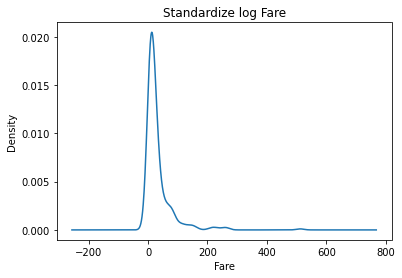

In [634]:
df_train.Fare.plot(kind='kde')
plt.title('Standardize log Fare')
plt.xlabel('Fare')
plt.show()

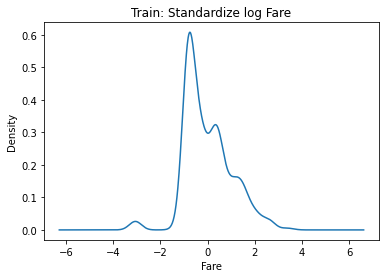

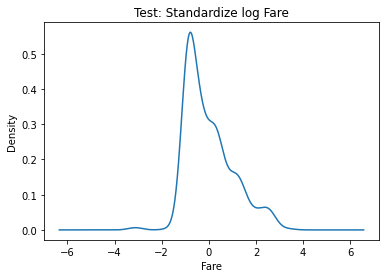

In [635]:
transformer = FunctionTransformer(np.log1p, validate=True)

df_train['Fare'] = scaler.fit_transform(transformer.transform(df_train[['Fare']]))
df_test['Fare'] = scaler.fit_transform(transformer.transform(df_test[['Fare']]))

df_train['Fare'].plot(kind='kde')
plt.title('Train: Standardize log Fare')
plt.xlabel('Fare')
plt.show()


df_test['Fare'].plot(kind='kde')
plt.title('Test: Standardize log Fare')
plt.xlabel('Fare')
plt.show()


In [636]:
df_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld,Connected_Survival
0,3,1,-0.56,1,0,-0.88,0,2,0,0,0,0,1,0,0,0,0,1,0.00,0.00
1,1,0,0.63,1,0,1.36,0,2,1,0,0,0,0,1,1,1,0,0,0.00,0.50
2,3,0,-0.26,0,0,-0.80,1,0,0,0,0,1,0,0,1,0,0,1,0.00,0.50
3,1,0,0.40,1,0,1.06,0,2,1,0,0,0,0,1,1,0,0,1,0.00,0.50
4,3,1,0.40,0,0,-0.78,1,0,0,0,0,0,1,0,0,0,0,1,0.00,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,-0.19,0,0,-0.33,1,0,0,1,0,0,0,0,0,0,0,1,0.00,0.50
887,1,0,-0.78,0,0,0.49,1,0,0,0,0,1,0,0,1,0,0,1,0.00,0.50
888,3,0,-1.60,1,2,0.24,0,4,0,0,0,1,0,0,0,0,0,1,1.00,0.50
889,1,1,-0.26,0,0,0.49,1,0,0,0,0,0,1,0,1,1,0,0,0.00,0.50


### Feature selection

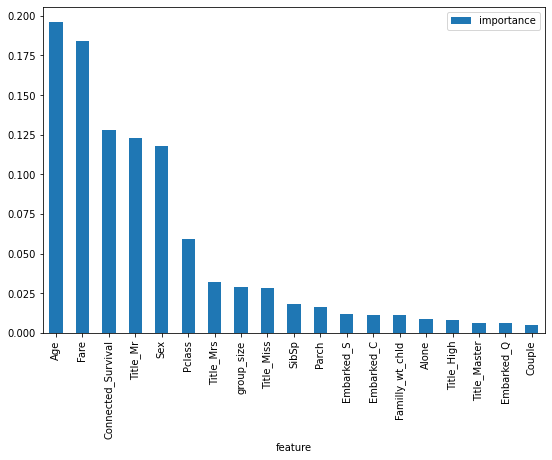

In [637]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=2)


model.fit(X_train,y_train)
importance = pd.DataFrame({'feature':X_train.columns, 'importance': np.round(model.feature_importances_,3)}).sort_values('importance', ascending=False).set_index('feature')
importance.plot(kind='bar', rot=90, figsize=(9,6))
plt.show()

In [638]:
importance.index

Index(['Age', 'Fare', 'Connected_Survival', 'Title_Mr', 'Sex', 'Pclass',
       'Title_Mrs', 'group_size', 'Title_Miss', 'SibSp', 'Parch', 'Embarked_S',
       'Embarked_C', 'Familly_wt_chld', 'Alone', 'Title_High', 'Title_Master',
       'Embarked_Q', 'Couple'],
      dtype='object', name='feature')

In [639]:
selected_cols = ['Age', 'Fare', 'Connected_Survival', 'Title_Mr', 'Sex', 'Pclass',
       'Title_Mrs', 'group_size', 'Title_Miss', 'Title_High', 'Title_Master','Survived']

In [640]:
df_train = df_train[selected_cols]
df_test = df_test[selected_cols]

### Model selection

In [641]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [642]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [643]:
clf = LazyClassifier(ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

 14%|█▍        | 4/29 [00:00<00:02, 11.03it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 29/29 [00:01<00:00, 18.46it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LabelPropagation                   0.88               0.87     0.87      0.88   
LabelSpreading                     0.88               0.87     0.87      0.88   
LGBMClassifier                     0.86               0.86     0.86      0.86   
RidgeClassifierCV                  0.87               0.86     0.86      0.87   
RidgeClassifier                    0.87               0.86     0.86      0.87   
LogisticRegression                 0.87               0.86     0.86      0.87   
LinearDiscriminantAnalysis         0.87               0.86     0.86      0.87   
LinearSVC                          0.87               0.86     0.86      0.87   
CalibratedClassifierCV             0.87               0.86     0.86      0.87   
SG

### Model tuning: Grid search


Model selected: LGBMClassifier, XGBClassifier, AdaBoostClassifier, LogisticRegression, SVC, RandomForestClassifier, Decision Tree
,KNeighborsClassifier

In [644]:
def grid_test(model_name, model, parameters, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test ):
  
  model = GridSearchCV(
    model, 
    parameters, 
    cv=5,
    scoring='accuracy',
)
  
  model.fit(X_train, y_train)
  # y_pred = model.predict(X_test)

  # Mean cross-validated score of the best_estimator
  print(model_name, ': ', model.best_score_, '\n')
  # print(classification_report(y_test, y_pred),'\n')


  # return model_name, round(accuracy_score(y_test, y_pred)*100, 2), model.best_estimator_
  return model_name, model.best_score_, model.best_estimator_



In [645]:
# good
lgbm_param = {
    'n_estimators': [5, 10, 15, 25, 50, 100, 125, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [7, 15, 31],
}

# good
log_reg_param = {
    "penalty": ["l1", "l2"],

}

# good
xgb_param = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

# good
ada_param = {
    'n_estimators': [70, 100, 150, 200, 250,300, 400],
    'learning_rate': [0.01, 0.05, 0.1]
}

# good
svc_param = {
    "C": [0.001, 0.01, 0.1, 0.5, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

# good
knn_param = {
    'n_neighbors':[5, 10, 15, 20, 25],
    "weights": ["uniform", "distance"]
}

# good
rf_param = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13]
}

# good
d_tree_param =  {
    "max_depth": [3, 5, 7, 9, 11, 13]
}

In [646]:
# lgbm = LGBMClassifier(random_state= 42)
log_reg = LogisticRegression(random_state= 42)
xgb = xgboost.XGBClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
d_tree =  DecisionTreeClassifier(random_state=42)

models = [('LogisticRegression',log_reg, log_reg_param), ('XGBClassifier',xgb, xgb_param), 
          ('AdaBoostClassifier',ada, ada_param), ('SVC',svc, svc_param), ('KNeighborsClassifier',knn, knn_param), 
          ('RandomForestClassifier',rf, rf_param), ('Decision Tree',d_tree, d_tree_param) ]

In [647]:
acc_dic={}
model_dic={}


for model in models:
  name,acc, best_model = grid_test(model[0],model[1],model[2])
  acc_dic[name] = acc
  model_dic[name] = best_model

LogisticRegression :  0.8622825721018966 

XGBClassifier :  0.8623274604421501 

AdaBoostClassifier :  0.8637975535854562 

SVC :  0.8592974974750309 

KNeighborsClassifier :  0.8308495118392998 

RandomForestClassifier :  0.8682976096958814 

Decision Tree :  0.8592862753899675 



In [648]:
pd.DataFrame.from_dict(acc_dic, orient='index', columns=['Mean CV Accuracy']).sort_values(by='Mean CV Accuracy', ascending=False)

,Mean CV Accuracy
RandomForestClassifier,0.87
AdaBoostClassifier,0.86
XGBClassifier,0.86
LogisticRegression,0.86
SVC,0.86
Decision Tree,0.86
KNeighborsClassifier,0.83


In [649]:
# param_dic
model_dic

{'AdaBoostClassifier': AdaBoostClassifier(learning_rate=0.05, n_estimators=150, random_state=42),
 'Decision Tree': DecisionTreeClassifier(max_depth=3, random_state=42),
 'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=25),
 'LogisticRegression': LogisticRegression(random_state=42),
 'RandomForestClassifier': RandomForestClassifier(max_depth=11, n_estimators=15, random_state=42),
 'SVC': SVC(C=0.5, kernel='linear', random_state=42),
 'XGBClassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='

In [650]:
# del model_dic['KNeighborsClassifier']

In [651]:
merge_dic={}

for name in model_dic:
  clf = model_dic[name]
  clf.fit(X, y)
  merge_dic[name] = clf.predict(df_test.drop('Survived', axis =1)).astype(int)
  try:
    print(sorted(list(zip(X.columns, clf.feature_importances_)), key= lambda x: x[1], reverse =True))
  except:
    pass



[('Title_Mr', 0.44055337), ('Sex', 0.2207235), ('Connected_Survival', 0.14359803), ('Pclass', 0.055487707), ('Title_High', 0.051033624), ('Fare', 0.030312808), ('Age', 0.020293158), ('group_size', 0.019132487), ('Title_Mrs', 0.018865246), ('Title_Miss', 0.0), ('Title_Master', 0.0)]
[('Connected_Survival', 0.30666666666666664), ('Sex', 0.20666666666666667), ('Fare', 0.12666666666666668), ('Title_Mr', 0.1), ('Pclass', 0.07333333333333333), ('Age', 0.06666666666666667), ('group_size', 0.06), ('Title_Mrs', 0.04), ('Title_Master', 0.02), ('Title_Miss', 0.0), ('Title_High', 0.0)]
[('Connected_Survival', 0.19264316002428414), ('Fare', 0.16928464759383838), ('Title_Mr', 0.16519173517117558), ('Age', 0.15241349077108826), ('Sex', 0.09809834981432293), ('Pclass', 0.06696274153989282), ('group_size', 0.049104385048042196), ('Title_Mrs', 0.046761232307283254), ('Title_Miss', 0.030941130604998444), ('Title_Master', 0.01490387052670376), ('Title_High', 0.013695256598370394)]
[('Title_Mr', 0.55301028

In [652]:
df_pred = pd.DataFrame(merge_dic)
df_pred.head()

,LogisticRegression,XGBClassifier,AdaBoostClassifier,SVC,KNeighborsClassifier,RandomForestClassifier,Decision Tree
0,0,0,0,0,0,0,0
1,0,1,1,1,0,1,1
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1


In [653]:
# np.round(df_pred.apply(sum, axis=1) / df_pred.shape[1]).astype(int)

In [654]:
# y_pred = np.round(df_pred.apply(sum, axis=1) / df_pred.shape[1]).astype(int)

# submission = pd.concat([pd.Series(df_test.index+1, name='PassengerId'), pd.Series(y_pred, name='Survived')], axis=1)

# submission.to_csv('new_submission.csv', index=False)

In [655]:
# top 6% 
y_pred = df_pred['RandomForestClassifier']

submission = pd.concat([pd.Series(df_test.index+1, name='PassengerId'), pd.Series(y_pred, name='Survived')], axis=1)

submission.to_csv('RandomForestClassifier5.csv', index=False)